In [3]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

<xarray.Dataset> Size: 12kB
Dimensions:      (depth_index: 115, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 920B 1 2 3 4 5 6 ... 111 112 113 114 115
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 11kB ...

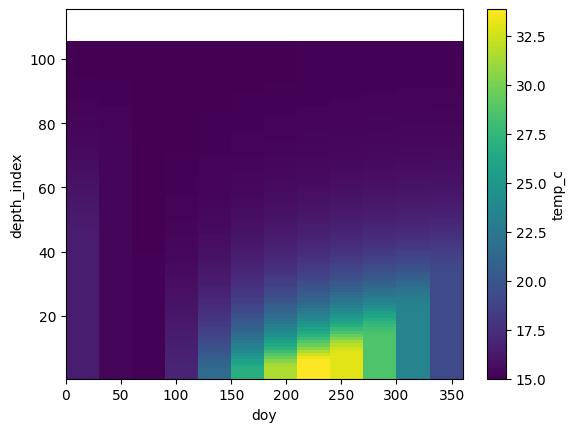

In [4]:
# Load lake data
lakedata =  xr.open_dataset('PyramidLake_105m.nc')
lakedata['temp_c'].plot()
lakedata

In [5]:
def clumped_sensor(temp_c, model):
        if model == 'I-CDES90':
            cap47 = 0.0004 * 10**6 / (temp_c + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            cap47 = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return cap47 # returns model eq back to caller (clumped_sensor)

In [6]:
def clumped_temperature(cap47, model):
        if model == 'I-CDES90':
            temp_c =  ( (20 * (np.sqrt(cap47 - 0.154))) / (cap47 - 0.154) ) - 273.15 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Kelvin to Celcius) # not including +/- uncertainties, can add later, solving for T
        elif model == 'CDES90': 
            temp_c = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return temp_c # returns model eq back to caller (clumped_temperature)   

In [62]:
def generate_weights(depth, weight_type): #add so that it adds weights to doy too based off notes (for loop?)
    """
    Generate a depth-weighting function.

    Args:
        depths (np.ndarray or pd.Series): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == 'uniform':
        weights = np.repeat(1 / len(depth), len(depth))
    
    elif weight_type == 'surface':
        depth[0] = 1  # Set the surface weight to 1
        weights = np.array(depth[0])  # Initialize all weights to 0
        
    
    elif weight_type == 'normal_dist':
        depth_index_mean = round(depth.values.mean(), 2)
        depth_index_std = round(depth.values.std(), 2)
        weights = (1 / (depth_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depth - depth_index_mean) / depth_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError('Weight type not recognized')
    
    return weights



In [8]:
MAMJ = range(60, 182), # March to June
AMJ = range(91, 182), # April to June  
AMJJ = range(91, 213), # April to July
AMJJASO = range(91, 305), # April to October
JJA = range(152, 244), # July to August 
ASO = range(213, 305), # August to October
January = range(0, 32),
February = range(32, 60),
March = range(60, 91),
April = range(91, 121),
May = range(121, 152),
June = range(152, 182),
July = range(182, 213),
August = range(213, 244),
September = range(244, 274),
October = range(274, 305),
November = range(305, 335),
December = range(335, 366)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

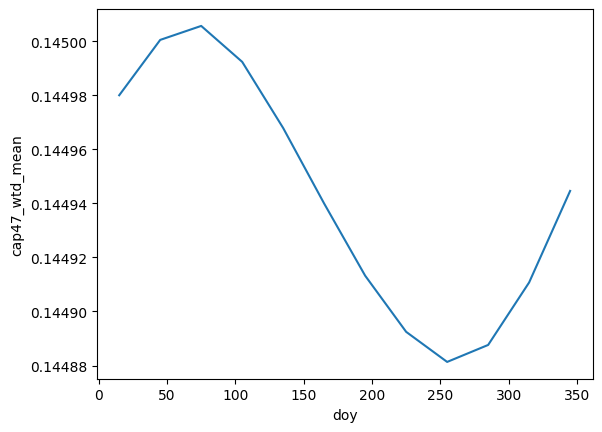

In [64]:
timesteps = lakedata['doy'].values
depth = pd.DataFrame(lakedata['depth_index'])

for ts in (timesteps) :
    tmpds = lakedata.sel(doy = ts) # pull out this timestep
    tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

    temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
     
    cap47 = clumped_sensor(temp_c, 'I-CDES90')
    cap47 = pd.DataFrame(cap47).copy()
    cap47 = cap47.rename(columns={'temp_c': 'cap47'})

    depth_weights = generate_weights(depth, 'surface')  
    
    if ts == timesteps[0]:
        df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
        cap47_wtd_mean = (pd.DataFrame(cap47)['cap47'] * depth_weights).sum() / depth_weights.sum()
        temp_c_wtd_mean = (temp_c*depth_weights[0]).sum() / depth_weights[0].sum()
        df = df.assign(temp_c_wtd_mean = temp_c_wtd_mean)
        df = df.assign(cap47_wtd_mean = cap47_wtd_mean)
    else:
       tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
       
       cap47_wtd_mean = (pd.DataFrame(cap47)['cap47'] * depth_weights).sum() / depth_weights.sum()
       temp_c_wtd_mean = (temp_c*depth_weights[0]).sum() / depth_weights[0].sum()
       
       tdf = tdf.assign(temp_c_wtd_mean = temp_c_wtd_mean)
       tdf = tdf.assign(cap47_wtd_mean = cap47_wtd_mean)
       df = pd.concat([tdf, df], ignore_index=True)
       df = df.dropna()      


df = df.set_index('doy', drop=True)
df = xr.Dataset.from_dataframe(df)
fig1 = df['cap47_wtd_mean']
fig1.plot()
depth_weights

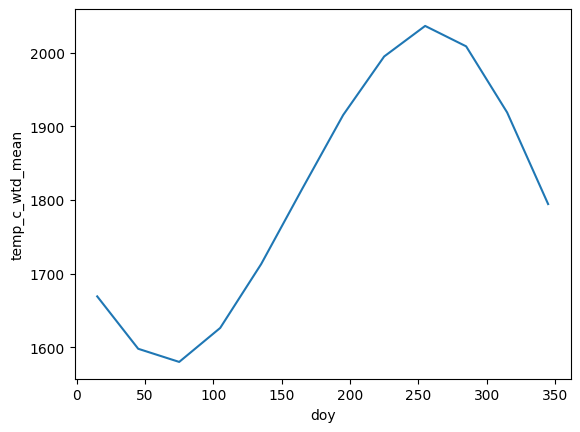

In [47]:
fig2 = df['temp_c_wtd_mean']
fig2.plot()

In [22]:
timesteps = df['doy']

time_weights = generate_weights(timesteps, 'surface')  

df['cap47_wtd_mean'] = (df['cap47_wtd_mean'] * time_weights).sum() / time_weights.sum()
df['temp_c_wtd_mean'] = (df['temp_c_wtd_mean'] * time_weights).sum() / time_weights.sum()

print(df['cap47_wtd_mean'].values)
print(df['temp_c_wtd_mean'].values)
df['cap47_wtd_mean_T'] = clumped_temperature(df['cap47_wtd_mean'], 'I-CDES90')
print(df['cap47_wtd_mean_T'].values)

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=1